### Food Vision Project

In [ ]:
!wget 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

--2022-06-29 07:00:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-29 07:00:29 (71.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import helper_functions as hf

In [ ]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                   split = ['train', 'validation'],
                                   shuffle_files=True,
                                   as_supervised=True, #data gets returned in tuple(train, test)
                                   with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteUBSJ4D/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteUBSJ4D/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Find

* Class names
* Shape of our input data
* Data type of our input data
* Labels(one-hot encoded or are they label encoded)
* Do the labels match up with class names?

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_data

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one_sample:
  print(image.shape, image.dtype)
  print(label , label.dtype, class_names[label.numpy()])

(384, 512, 3) <dtype: 'uint8'>
tf.Tensor(56, shape=(), dtype=int64) <dtype: 'int64'> huevos_rancheros


Labels are not one hot encoded

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow Datasets

(-0.5, 511.5, 383.5, -0.5)

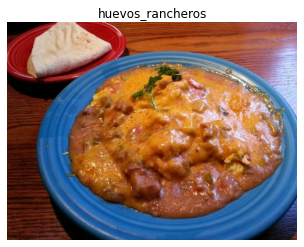

In [ ]:
import matplotlib.pyplot as plt


plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

### Create preprocessing functions for data

* Data is in uint8 datatype -- should be in float32 or (float32 or float16 for mixed precision)
* Images are of different size
* Images are not scaled (not between 0 & 255)
* if from directory is used batch size and input shape are set---
all of the tensors within a batch to be of the same size

* Scaled (between 0 & 1 ) works better


If EfficientNetBX is used rescale is not required


We need to :
* Reshape our  all images to same size
* Convert dtype from uint8 to float32
  



In [ ]:

# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f'Original Image shape : {image.shape}')
print(f'Processed Image shape : {preprocessed_img.shape}')
print(f'Datatype of Image : {image.dtype}')
print(f'Datatype of Processed Image : {preprocessed_img.dtype}')

Original Image shape : (384, 512, 3)
Processed Image shape : (224, 224, 3)
Datatype of Image : <dtype: 'uint8'>
Datatype of Processed Image : <dtype: 'float32'>


In [ ]:
image[:2], image.shape, image.dtype

(<tf.Tensor: shape=(2, 512, 3), dtype=uint8, numpy=
 array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [144,  81, 102],
         [142,  78, 102],
         [139,  75,  99]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [159,  96, 115],
         [154,  89, 111],
         [146,  83, 104]]], dtype=uint8)>,
 TensorShape([384, 512, 3]),
 tf.uint8)

In [ ]:
preprocessed_img.shape, preprocessed_img.dtype

(TensorShape([224, 224, 3]), tf.float32)

### Batch and prepare data

In [ ]:
train_data

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Map, Batch, Prefetch happens on CPU

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster), batch 32--turns datatasets into batchs also good for efficeint computing, prefeth- while the model is finding patterns prepare next batch
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

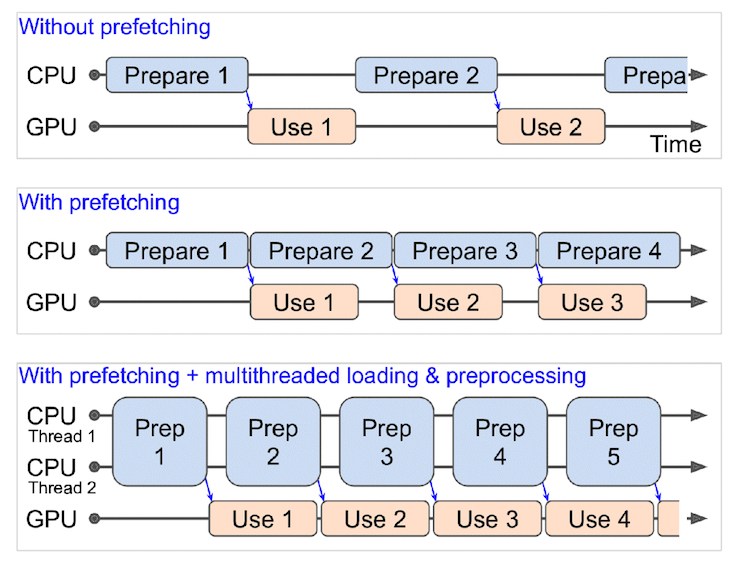

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Create modelling callbacks

* Model Checkpoint callback - to save our model's progress after feature extraction

* Early stopping callback - 

In [ ]:
checkpoint_path = 'model_checkpoints/cp.ckpt'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_acc',
                                                      save_best_only= True,
                                                      save_weights_only = True,
                                                      verbose = 0)

# save the best model with high val accu, verbose=0-don't display anything

### Model

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs,outputs)


model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


model.summary()

history = model.fit(train_data,
                    epochs = 5,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.5*len(test_data)),
                    callbacks = [model_checkpoint])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.8251 - accuracy: 0.5562WARNING:tenso

2368/2368 [==============================] - 208s 80ms/step - loss: 1.8251 - accuracy: 0.5562 - val_loss: 1.2270 - val_accuracy: 0.6780
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2948 - accuracy: 0.6660WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 189s 79ms/step - loss: 1.2949 - accuracy: 0.6660 - val_loss: 1.1191 - val_accuracy: 0.7017
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.1444 - accuracy: 0.7027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 80ms/step - loss: 1.1444 - accuracy: 0.7027 - val_loss: 1.0909 - val_accuracy: 0.7030
Epoch 4/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0458 - accuracy: 0.7259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 186s 78ms/step - loss: 1.0459 - accuracy: 0.7258 - val_loss: 1.0687 - val_accuracy: 0.7044
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9725 - accuracy: 0.7449WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 186s 78ms/step - loss: 0.9724 - accuracy: 0.7449 - val_loss: 1.0636 - val_accuracy: 0.7086


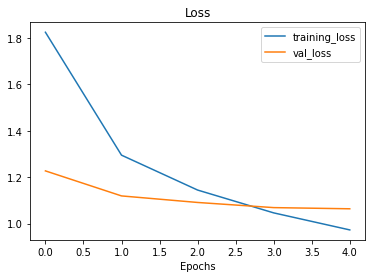

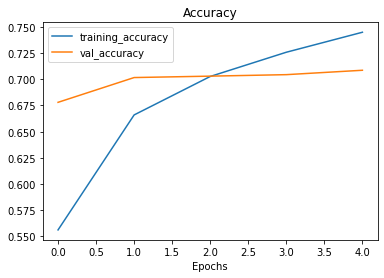

In [ ]:
hf.plot_loss_curves(history)

### Fine Tuning

In [ ]:
model.layers

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable)

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable  = False

In [ ]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


model.summary()

history = model.fit(train_data,
                    epochs = 5,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.5*len(test_data)),
                    callbacks = [model_checkpoint])

In [ ]:
history.epoch

[0, 1, 2, 3, 4]

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ['accuracy'])



history_1 = model.fit(train_data,
                    epochs = 10,
                    initial_epoch = history.epoch[-1],
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.5*len(test_data)),
                    callbacks = [model_checkpoint])

Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2368/2368 [==============================] - ETA: 0s - loss: 0.8345 - accuracy: 0.7770WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 198s 80ms/step - loss: 0.8345 - accuracy: 0.7770 - val_loss: 1.0030 - val_accuracy: 0.7247
Epoch 6/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.8157WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 80ms/step - loss: 0.6934 - accuracy: 0.8157 - val_loss: 1.0097 - val_accuracy: 0.7301
Epoch 7/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.5875 - accuracy: 0.8449WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 80ms/step - loss: 0.5875 - accuracy: 0.8449 - val_loss: 1.0138 - val_accuracy: 0.7300
Epoch 8/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.4987 - accuracy: 0.8702WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 80ms/step - loss: 0.4988 - accuracy: 0.8702 - val_loss: 1.0358 - val_accuracy: 0.7298
Epoch 9/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.4194 - accuracy: 0.8941WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 80ms/step - loss: 0.4195 - accuracy: 0.8941 - val_loss: 1.0613 - val_accuracy: 0.7282
Epoch 10/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.3505 - accuracy: 0.9139WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 190s 80ms/step - loss: 0.3505 - accuracy: 0.9139 - val_loss: 1.0964 - val_accuracy: 0.7278


### Model 2

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = True

inputs = tf.keras.layers.Input(shape = input_shape)

x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_1.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks = [model_checkpoint, tf.keras.callbacks.EarlyStopping(monitor = 'val_loss')])

Epoch 1/10
2367/2368 [============================>.] - ETA: 0s - loss: 1.6245 - accuracy: 0.5856WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 224s 92ms/step - loss: 1.6246 - accuracy: 0.5856 - val_loss: 1.0388 - val_accuracy: 0.7116
Epoch 2/10
2367/2368 [============================>.] - ETA: 0s - loss: 1.1621 - accuracy: 0.6886WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 252s 106ms/step - loss: 1.1621 - accuracy: 0.6886 - val_loss: 0.9440 - val_accuracy: 0.7381
